# Backtesting a simple trend following strategy

Saeed Amen - saeed@cuemacro.com

Here, we demonstrate how to develop a trading strategy in finmarketpy (https://www.github.com/cuemacro/finmarketpy). In this example, we show how to do a backtest of a simple trend following strategy using the `Backtest` class. The trading strategy involves buying spot, when it is above the 200D simple moving average and selling spot, when it below the 200D simple moving average.

First, let's do all the imports.

In [3]:
# for backtest and loading data
from finmarketpy.backtest import BacktestRequest, Backtest
from findatapy.market import Market, MarketDataRequest, MarketDataGenerator
from findatapy.util.fxconv import FXConv

# for logging
from findatapy.util.loggermanager import LoggerManager

# for signal generation
from finmarketpy.economics import TechIndicator, TechParams

# for plotting
from chartpy import Chart, Style

Create a logger.

In [4]:
# housekeeping
logger = LoggerManager().getLogger(__name__)

import datetime

Let's load up market data. Note you will need to type in your Quandl API key below (or set it as an environment variable before running this Jupyter notebook). You can get a free API key from Quandl.com, once you sign up for a free account.

In [5]:
try:
    import os
    
    QUANDL_API_KEY = os.environ['QUANDL_API_KEY']
except:
    QUANDL_API_KEY = 'TYPE_YOUR_KEY_HERE'

# pick USD crosses in G10 FX
# note: we are calculating returns from spot (it is much better to use to total return
# indices for FX, which include carry)
logger.info("Loading asset data...")

tickers = ['EURUSD', 'USDJPY', 'GBPUSD', 'AUDUSD', 'USDCAD',
           'NZDUSD', 'USDCHF', 'USDNOK', 'USDSEK']

vendor_tickers = ['FRED/DEXUSEU', 'FRED/DEXJPUS', 'FRED/DEXUSUK', 'FRED/DEXUSAL', 'FRED/DEXCAUS',
                  'FRED/DEXUSNZ', 'FRED/DEXSZUS', 'FRED/DEXNOUS', 'FRED/DEXSDUS']

md_request = MarketDataRequest(
    start_date="01 Jan 1989",  # start date
    finish_date=datetime.date.today(),  # finish date
    freq='daily',  # daily data
    data_source='quandl',  # use Quandl as data source
    tickers=tickers,  # ticker (findatapy)
    fields=['close'],  # which fields to download
    vendor_tickers=vendor_tickers,  # ticker (Quandl)
    vendor_fields=['close'],  # which Bloomberg fields to download
    cache_algo='internet_load_return',
    quandl_api_key=QUANDL_API_KEY)  # how to return data

market = Market(market_data_generator=MarketDataGenerator())

asset_df = market.fetch_market(md_request)
spot_df = asset_df

2020-11-12 14:10:06,928 - __main__ - INFO - Loading asset data...
2020-11-12 14:10:07,875 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-12 14:10:07,875 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-12 14:10:07,880 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-12 14:10:07,880 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-12 14:10:10,429 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['EURUSD.close']
2020-11-12 14:10:10,838 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-12 14:10:11,443 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['AUDUSD.close']
2020-11-12 14:10:11,558 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-12 14:10:12,412 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['USDJPY.close']
2020-11-12 14:10:12,418 - findatapy.market.datavendorweb - INFO - C

Let's define all the parameters for the backtest, start/finish dates, technical indicator we'll use etc.

In [10]:
backtest = Backtest()
br = BacktestRequest()
fxconv = FXConv()

# get all asset data
br.start_date = "02 Jan 1990"
br.finish_date = datetime.datetime.utcnow()
br.spot_tc_bp = 0  # 2.5 bps bid/ask spread
br.ann_factor = 252

# have vol target for each signal
br.signal_vol_adjust = True
br.signal_vol_target = 0.05
br.signal_vol_max_leverage = 3
br.signal_vol_periods = 60
br.signal_vol_obs_in_year = 252
br.signal_vol_rebalance_freq = 'BM'
br.signal_vol_resample_freq = None

tech_params = TechParams();
tech_params.sma_period = 200;
indicator = 'SMA'

Calculate the technical indicator and the trading signal.

In [11]:
logger.info("Running backtest...")

# use technical indicator to create signals
# (we could obviously create whatever function we wanted for generating the signal dataframe)
tech_ind = TechIndicator()
tech_ind.create_tech_ind(spot_df, indicator, tech_params);
signal_df = tech_ind.get_signal()

2020-11-12 16:19:03,860 - __main__ - INFO - Running backtest...


Run the backtest using the market data, signal etc.

In [12]:
contract_value_df = None

# use the same data for generating signals
backtest.calculate_trading_PnL(br, asset_df, signal_df, contract_value_df, run_in_parallel=False)
port = backtest.portfolio_cum()
port.columns = [indicator + ' = ' + str(tech_params.sma_period) + ' ' + str(backtest.portfolio_pnl_desc()[0])]
signals = backtest.portfolio_signal()

# print the last positions (we could also save as CSV etc.)
print(signals.tail(1))

2020-11-12 16:19:04,941 - finmarketpy.backtest.backtestengine - INFO - Calculating trading P&L...
2020-11-12 16:19:04,982 - finmarketpy.backtest.backtestengine - INFO - Cumulative index calculations
2020-11-12 16:19:04,993 - finmarketpy.backtest.backtestengine - INFO - Completed cumulative index calculations
            EURUSD.close SMA Signal  USDJPY.close SMA Signal  \
Date                                                           
2020-11-06                  0.08321                -0.102708   

            GBPUSD.close SMA Signal  AUDUSD.close SMA Signal  \
Date                                                           
2020-11-06                 0.062994                 0.060006   

            USDCAD.close SMA Signal  NZDUSD.close SMA Signal  \
Date                                                           
2020-11-06                -0.093499                 0.057194   

            USDCHF.close SMA Signal  USDNOK.close SMA Signal  \
Date                                           

Finally display the portfolio cumulative index.

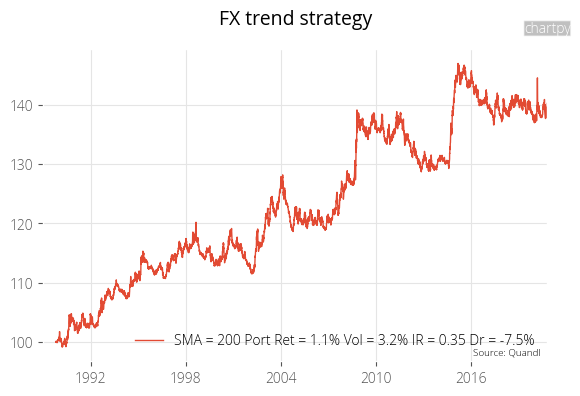

In [13]:
style = Style()
style.title = "FX trend strategy"
style.source = 'Quandl'
style.scale_factor = 1
style.file_output = 'fx-trend-example.png'

Chart().plot(port, style=style)